<a href="https://colab.research.google.com/github/iamdsc/text_biasness_detection/blob/master/text_biasness.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
pip install allennlp

In [0]:
pip install flair

In [0]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
from keras import backend as K
from keras import initializers, regularizers, constraints
import keras.layers as layers
from keras.models import Model, Sequential, load_model
from keras.engine.topology import Layer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint
from flair.data import Sentence
from flair.models import SequenceTagger
from flair.embeddings import ELMoEmbeddings

## Loading the data

In [0]:
def read_data_from_txt(filename, label):
  data = {}
  data['sentence'] = []
  data['label'] = []
  with open(filename, 'r') as f:
    for line in f:
      data['sentence'].append(line)
      data['label'].append(label)

  data_df = pd.DataFrame(data)
  return data_df

In [141]:
biased_data = read_data_from_txt('biased.txt', 1)
biased_data.head()

,sentence,label
0,"David J. Hanson Ph.D., Professor Emeritus of S...",1
1,While he continually puts forth these findings...,1
2,"According to the Iranian government, the shoot...",1
3,Games revolving around the kicking of a ball t...,1
4,"Irgun, shorthand for Irgun Tsvai Leumi, also s...",1


In [142]:
biased_data.shape

(1843, 2)

In [143]:
neutral_hard_data = read_data_from_txt('neutral_cw-hard.txt', 0)
neutral_hard_data.head()

,sentence,label
0,The success of BJJ versus the other martial ar...,0
1,"In all the games, the player is put in command...",0
2,"Potwari ( , also known as Pothohari or Pahari-...",0
3,"Hekmatyar's group, who, in October 1975, under...",0
4,After the Battle of Nicopolis in 1396 and the ...,0


In [10]:
neutral_hard_data.shape

(3109, 2)

In [144]:
neutral_featured_data = read_data_from_txt('neutral_featured.txt', 0)
neutral_featured_data.head()

,sentence,label
0,Astatine was first produced by bombarding bism...,0
1,"The hatched young, called squabs, are strongly...",0
2,In spite of early successes against invading I...,0
3,"The Trojans trailed 10–3 going into halftime, ...",0
4,"These bats possess long muzzles and long, exte...",0


In [12]:
neutral_featured_data.shape

(5000, 2)

In [145]:
neutral_type_balanced_data = read_data_from_txt('neutral_type_balanced.txt', 0)
neutral_type_balanced_data.head()

,sentence,label
0,Other functions of the haemolymph include woun...,0
1,"It was the fourth best-selling game of 2008, s...",0
2,"Sherwood Springer's ""No Land of Nod"", in the s...",0
3,"The Red Sox, winners of five of the first sixt...",0
4,The final part addresses the actual rise of al...,0


In [14]:
neutral_type_balanced_data.shape

(1994, 2)

### Number of Samples:
1.   Biased Data: 1843
2.   Neutral CW-Hard: 3109
3.   Neutral Featured: 5000
4.   Neutral Type-balanced: 1994



In [146]:
# taking equal number of neutral sentences
neutral_type_balanced_data = neutral_type_balanced_data[:len(biased_data)]
neutral_type_balanced_data.shape

(1843, 2)

In [0]:
# concatenating and shuffling the data
text_data = pd.concat([biased_data, neutral_type_balanced_data]).sample(frac=1).reset_index(drop=True)

In [148]:
text_data.shape

(3686, 2)

In [149]:
text_data.head()

,sentence,label
0,"Plans are downloadable from his website, with ...",1
1,It then straightens its front legs.\n,0
2,The game is praised for its free play abilitie...,1
3,Square Enix believed that developing a new eng...,0
4,"In Japan, the general public tends to think th...",1


## Defining helper functions

In [0]:
# to compute fmeasure as custom metric
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [0]:
# helper function to plot the results
def plot_result(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  f1 = history.history['f1']
  val_f1 = history.history['val_f1']
  
  epochs = range(1, len(acc)+1)

  plt.plot(epochs, acc, label='Training acc')
  plt.plot(epochs, val_acc, label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.xlabel('epochs')
  plt.ylabel('acc')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, label='Training loss')
  plt.plot(epochs, val_loss, label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('epochs')
  plt.ylabel('loss')
  plt.legend()

  plt.figure()

  plt.plot(epochs, f1, label='Training fmeasure')
  plt.plot(epochs, val_f1, label='Validation fmeasure')
  plt.title('Training and validation fmeasure')
  plt.xlabel('epochs')
  plt.ylabel('f1')
  plt.legend()
  
  plt.show()

In [0]:
maxlen = 50

In [0]:
# Create dataset taking max 50 words in each sentence
data = text_data['sentence'].tolist()
data = [' '.join(t.split()[:maxlen]) for t in data]
data = np.array(data, dtype=object)[:, np.newaxis]
label = text_data['label'].tolist()
flatten_data = data.flatten()

## Building Elmo Embeddings using flair

In [154]:
# init embedding
embedding = ELMoEmbeddings()

# Embedding array - [3686, 50, 3072]
elmo_embedding = []
for sent in flatten_data:
  sent_embedding = []
  sent = sent.split()[:50]
  sent.extend(['PAD']*(50-len(sent)))
  sent = ' '.join(sent)  
  sentence = Sentence(sent)
  embedding.embed(sentence)
  for token in sentence:
    sent_embedding.append(token.embedding.cpu().numpy())
  elmo_embedding.append(np.array(sent_embedding))
elmo_embedding = np.array(elmo_embedding)
print(elmo_embedding.shape)

(3686, 50, 3072)


In [0]:
# build the model 1
def build_elmo_dense():
  """ Using Dense layer over elmo-embedding layer """
  inp = layers.Input(shape=(maxlen, 3072,))
  dense = layers.Dense(64, activation='relu')(inp)
  x = layers.Dropout(0.5)(dense)
  x = layers.Flatten()(x)
  pred = layers.Dense(1, activation='sigmoid')(x)
  model = Model(inputs=inp, outputs=pred)
  model.compile(loss='binary_crossentropy',
                optimizer='rmsprop',
                metrics=['accuracy', f1])
  model.summary()
  return model

In [0]:
elmo_dense = build_elmo_dense()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 50, 3072)          0         
_________________________________________________________________
dense_26 (Dense)             (None, 50, 64)            196672    
_________________________________________________________________
dropout_4 (Dropout)          (None, 50, 64)            0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 3200)              0         
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 3201      
Total params: 199,873
Trainable params: 199,873
Non-trainable params: 0
_________________________________________________________________


In [0]:
# fit the model
history = elmo_dense.fit(elmo_embedding, label, validation_split=0.1, epochs=4, batch_size=32)

Train on 3317 samples, validate on 369 samples
Epoch 1/4
3317/3317 [==============================] - 4s 1ms/step - loss: 0.6839 - acc: 0.7163 - f1: 0.6971 - val_loss: 0.3944 - val_acc: 0.8347 - val_f1: 0.8516
Epoch 2/4
3317/3317 [==============================] - 2s 644us/step - loss: 0.3458 - acc: 0.8550 - f1: 0.8482 - val_loss: 0.4097 - val_acc: 0.8130 - val_f1: 0.8059
Epoch 3/4
3317/3317 [==============================] - 2s 609us/step - loss: 0.2508 - acc: 0.8945 - f1: 0.8896 - val_loss: 0.4247 - val_acc: 0.8211 - val_f1: 0.8381
Epoch 4/4
3317/3317 [==============================] - 2s 624us/step - loss: 0.1564 - acc: 0.9388 - f1: 0.9363 - val_loss: 0.4182 - val_acc: 0.8401 - val_f1: 0.8467


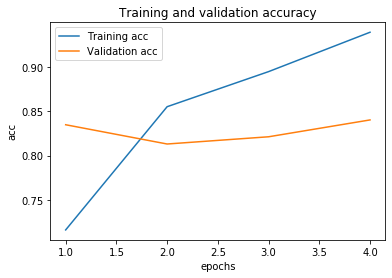

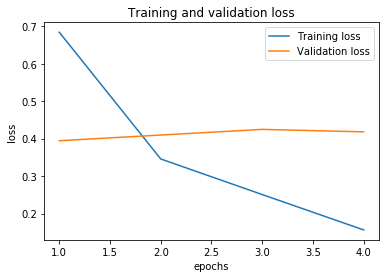

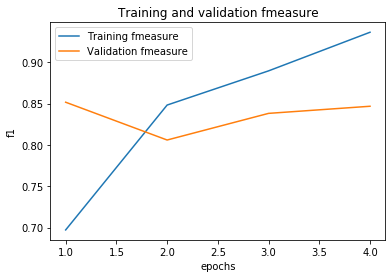

In [0]:
plot_result(history)

In [0]:
#build the model 2
def build_elmo_lstm():
  """ Using Bidirectional-LSTM over elmo-embedding layer """
  inp = layers.Input(shape=(maxlen, 3072,), name='input')
  lstm = layers.LSTM(128, dropout=0.3, name='lstm')(inp)
  x = layers.Dense(128, activation='relu', name='dense1')(lstm)
  x = layers.Dense(64, activation='relu', name='dense2')(x)
  pred = layers.Dense(1, activation='sigmoid', name='dense3')(x)
  model = Model(inputs=inp, outputs=pred, name='Elmo-LSTM Model')
  model.compile(loss='binary_crossentropy',
                optimizer='rmsprop',
                metrics=['accuracy', f1])
  model.summary()
  return model

In [176]:
elmo_lstm = build_elmo_lstm()

Model: "Elmo-LSTM Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 50, 3072)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               1638912   
_________________________________________________________________
dense1 (Dense)               (None, 128)               16512     
_________________________________________________________________
dense2 (Dense)               (None, 64)                8256      
_________________________________________________________________
dense3 (Dense)               (None, 1)                 65        
Total params: 1,663,745
Trainable params: 1,663,745
Non-trainable params: 0
_________________________________________________________________


In [177]:
# checkpoint
filepath="elmo_lstm_model-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

# fit the model
history = elmo_lstm.fit(elmo_embedding, label, validation_split=0.1, epochs=4, batch_size=32, callbacks=callbacks_list)

Train on 3317 samples, validate on 369 samples
Epoch 1/4
3317/3317 [==============================] - 24s 7ms/step - loss: 0.5664 - acc: 0.7112 - f1: 0.6596 - val_loss: 0.4354 - val_acc: 0.7886 - val_f1: 0.7713

Epoch 00001: val_acc improved from -inf to 0.78862, saving model to elmo_lstm_model-01-0.79.hdf5
Epoch 2/4
3317/3317 [==============================] - 10s 3ms/step - loss: 0.4165 - acc: 0.8215 - f1: 0.8170 - val_loss: 0.3715 - val_acc: 0.8401 - val_f1: 0.8413

Epoch 00002: val_acc improved from 0.78862 to 0.84011, saving model to elmo_lstm_model-02-0.84.hdf5
Epoch 3/4
3317/3317 [==============================] - 10s 3ms/step - loss: 0.3600 - acc: 0.8523 - f1: 0.8469 - val_loss: 0.3865 - val_acc: 0.8211 - val_f1: 0.8152

Epoch 00003: val_acc did not improve from 0.84011
Epoch 4/4
3317/3317 [==============================] - 10s 3ms/step - loss: 0.2871 - acc: 0.8851 - f1: 0.8795 - val_loss: 0.4473 - val_acc: 0.8293 - val_f1: 0.8403

Epoch 00004: val_acc did not improve from 0.84

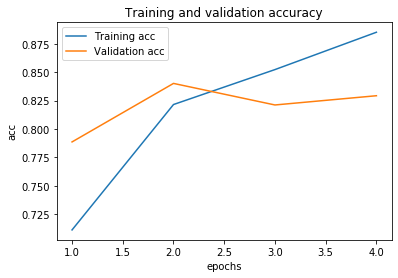

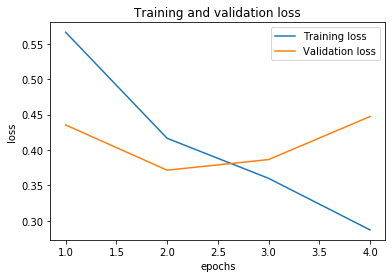

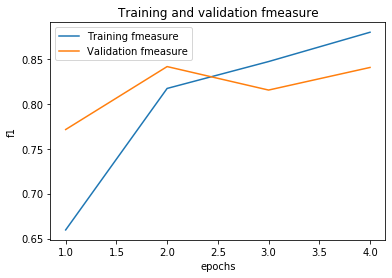

In [178]:
plot_result(history)

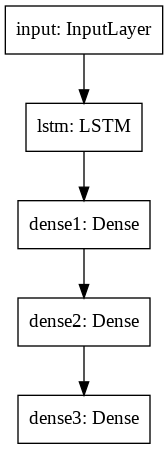

In [179]:
plot_model(elmo_lstm, to_file='elmo_lstm.png')

## Creating Custom Attention Layer

In [0]:
def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatible with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)
    

class AttentionWithContext(Layer):
    """
    Attention operation, with a context/query vector, for temporal data.
    Supports Masking.
    Follows the work of Yang et al. [https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf]
    "Hierarchical Attention Networks for Document Classification"
    by using a context vector to assist the attention
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        2D tensor with shape: `(samples, features)`.
    How to use:
    Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
    The dimensions are inferred based on the output shape of the RNN.
    Note: The layer has been tested with Keras 2.0.6
    Example:
        model.add(LSTM(64, return_sequences=True))
        model.add(AttentionWithContext())
        # next add a Dense layer (for classification/regression) or whatever...
    """
    def __init__(self,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True, **kwargs):

        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight((input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)

        self.u = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)

        super(AttentionWithContext, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        uit = dot_product(x, self.W)

        if self.bias:
            uit += self.b

        uit = K.tanh(uit)
        ait = dot_product(uit, self.u)

        a = K.exp(ait)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]

In [0]:
def build_elmo_lstm_attention():
    inp = layers.Input(shape=(maxlen, 3072,))
    x = layers.LSTM(64, dropout=0.5, return_sequences=True)(inp)
    x = AttentionWithContext()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)    
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    pred = layers.Dense(1, activation='sigmoid')(x)
    model = Model(inputs=inp, outputs=pred)
    model.compile(loss='binary_crossentropy',
                optimizer='rmsprop',
                metrics=['accuracy', f1])
    model.summary()
    return model

In [119]:
elmo_lstm_attention = build_elmo_lstm_attention()

Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_60 (InputLayer)        (None, 50, 3072)          0         
_________________________________________________________________
lstm_67 (LSTM)               (None, 50, 64)            803072    
_________________________________________________________________
attention_with_context_67 (A (None, 64)                4224      
_________________________________________________________________
dense_41 (Dense)             (None, 128)               8320      
_________________________________________________________________
dropout_21 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_42 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_22 (Dropout)         (None, 64)                0  

In [120]:
# fit the model
history = elmo_lstm_attention.fit(elmo_embedding, label, validation_split=0.1, epochs=4, batch_size=32)

Train on 3317 samples, validate on 369 samples
Epoch 1/4
3317/3317 [==============================] - 22s 6ms/step - loss: 0.5348 - acc: 0.7353 - f1: 0.7249 - val_loss: 0.4891 - val_acc: 0.7832 - val_f1: 0.8001
Epoch 2/4
3317/3317 [==============================] - 10s 3ms/step - loss: 0.3974 - acc: 0.8294 - f1: 0.8261 - val_loss: 0.4563 - val_acc: 0.7940 - val_f1: 0.7832
Epoch 3/4
3317/3317 [==============================] - 10s 3ms/step - loss: 0.3368 - acc: 0.8625 - f1: 0.8573 - val_loss: 0.4482 - val_acc: 0.8238 - val_f1: 0.8269
Epoch 4/4
3317/3317 [==============================] - 10s 3ms/step - loss: 0.2835 - acc: 0.8897 - f1: 0.8876 - val_loss: 0.5380 - val_acc: 0.8130 - val_f1: 0.8051


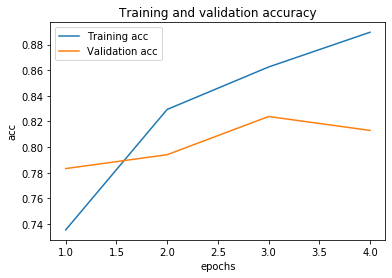

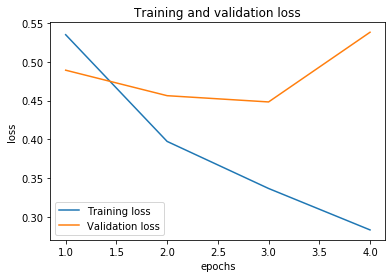

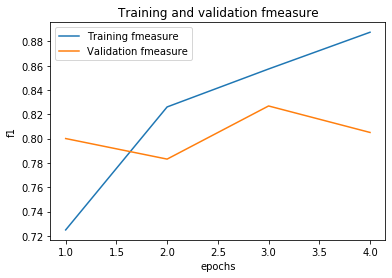

In [121]:
plot_result(history)

## Using POS tags of words in sentences

In [0]:
pos_tagger = SequenceTagger.load('pos-fast')
pos_tags = []
for sent in flatten_data:
  sentence = Sentence(sent)
  pos_tagger.predict(sentence)
  tagged_sentence = sentence.to_tagged_string()
  ## Replace that word from sentence 
  for j in sent.split():
    tagged_sentence = str(tagged_sentence).replace(j,"",1)    
  ## Removing < > symbols ##
  for j in  ['<','>']:
    tagged_sentence = str(tagged_sentence).replace(j,"")
    ## Removing redundant spaces
    tagged_sentence = re.sub(' +', ' ', str(tagged_sentence))
    tagged_sentence = str(tagged_sentence).lstrip()
  pos_tags.append(tagged_sentence)
# print(pos_tags[:5])

In [100]:
print(flatten_data[0])
print(pos_tags[0])
print(elmo_embedding[0])

The operations of the 509th Composite Group were treated to a lesser extent in the docudrama "The Beginning or the End" (1947), with Barry Nelson as Tibbets.
DET NOUN ADP DET ADJ PROPN PROPN VERB VERB ADP DET ADJ NOUN ADP DET NOUN PRON NOUN CCONJ DET PROPN NUM ADP PROPN PROPN ADP PROPN
[[-0.3288476   0.20216218 -0.5940115  ... -1.3839288   0.04014444
   0.36067542]
 [-0.09706307 -0.6824828   0.18596874 ... -1.0016967   1.0592575
   0.19844666]
 [ 0.24783461 -0.24896076  0.02219516 ... -1.8530749  -0.6374299
  -0.5472182 ]
 ...
 [-0.5276699   1.0594847  -0.17727263 ...  0.24792817 -0.45711735
  -0.18467829]
 [-0.5276699   1.0594847  -0.17727263 ...  0.10488677 -0.3012372
  -0.42728814]
 [-0.5276699   1.0594847  -0.17727263 ... -0.06258881 -0.1776095
  -0.437854  ]]


In [37]:
maxlen = 50
max_words = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(pos_tags)

sequences = tokenizer.texts_to_sequences(pos_tags)
word_index = tokenizer.word_index

print('Found %s unique tokens'%len(word_index))

# padding the sequences
pos_data = pad_sequences(sequences, maxlen=maxlen)

Found 63 unique tokens


In [39]:
print(pos_data.shape)
print(pos_data[:5])

(3686, 50)
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  5
   1  2  5  6  4  4  3  3  2  5  6  1  2  5  1  8  1  9  5  4 10  2  4  4
   2  4]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  4  3  5  6  1  8  3  6 11  3  9  4  3  3  2  8  6  1
   9  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  5  1  2
   1  6  1  2  1  1  9  1  2  1  8  3  3  2  4  1  2  6  1  3  3  5  6  1
   2  8]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  8  3  7  5
   1  2  5  6  1  2  5  6  9  6  7  2  5  6  1  1  6  2  4  8  3  3  2  6
   9  6]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2
   5  3  5  6  1  2  5  6  1  1  3  3  4  9  5  4  4  4  2  3  2  4  1  2
   6  1]]


In [0]:
def build_elmo_lstm_attn_pos_attn():
    inp1 = layers.Input(shape=(maxlen, 3072,), name='word_embedding') # To input elmo embeddings
    inp2 = layers.Input(shape=(maxlen,), name='word_POS_tag') # To input POS tag sequences
    
    x = layers.LSTM(64, dropout=0.3, return_sequences=True, name='lstm1')(inp1)
    x = AttentionWithContext()(x)
    
    y = layers.Embedding(max_words, 1024, input_length=maxlen, name='embedding')(inp2)
    y = layers.LSTM(64, dropout=0.3, return_sequences=True, name='lstm2')(y)
    
    y = AttentionWithContext()(y)
    
    z = layers.Concatenate(axis=-1, name='concatenate')([x, y])
    
    z = layers.Dense(128, activation='relu', name='dense1')(z)
    z = layers.Dropout(0.5, name='dropout1')(z)
    z = layers.Dense(64, activation='relu', name='dense2')(z)
    z = layers.Dropout(0.3, name='dropout2')(z)
    
    pred = layers.Dense(1, activation='sigmoid', name='dense3')(z)
    model = Model(inputs=[inp1,inp2], outputs=pred, name='Elmo-LSTM-Attn+POS-LSTM-Attn')
    model.compile(loss='binary_crossentropy',
                optimizer='rmsprop',
                metrics=['accuracy', f1])
    model.summary()
    return model

In [191]:
elmo_lstm_attn_pos_attn = build_elmo_lstm_attn_pos_attn()

Model: "Elmo-LSTM-Attn+POS-LSTM-Attn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
word_POS_tag (InputLayer)       (None, 50)           0                                            
__________________________________________________________________________________________________
word_embedding (InputLayer)     (None, 50, 3072)     0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 1024)     102400      word_POS_tag[0][0]               
__________________________________________________________________________________________________
lstm1 (LSTM)                    (None, 50, 64)       803072      word_embedding[0][0]             
_______________________________________________________________________

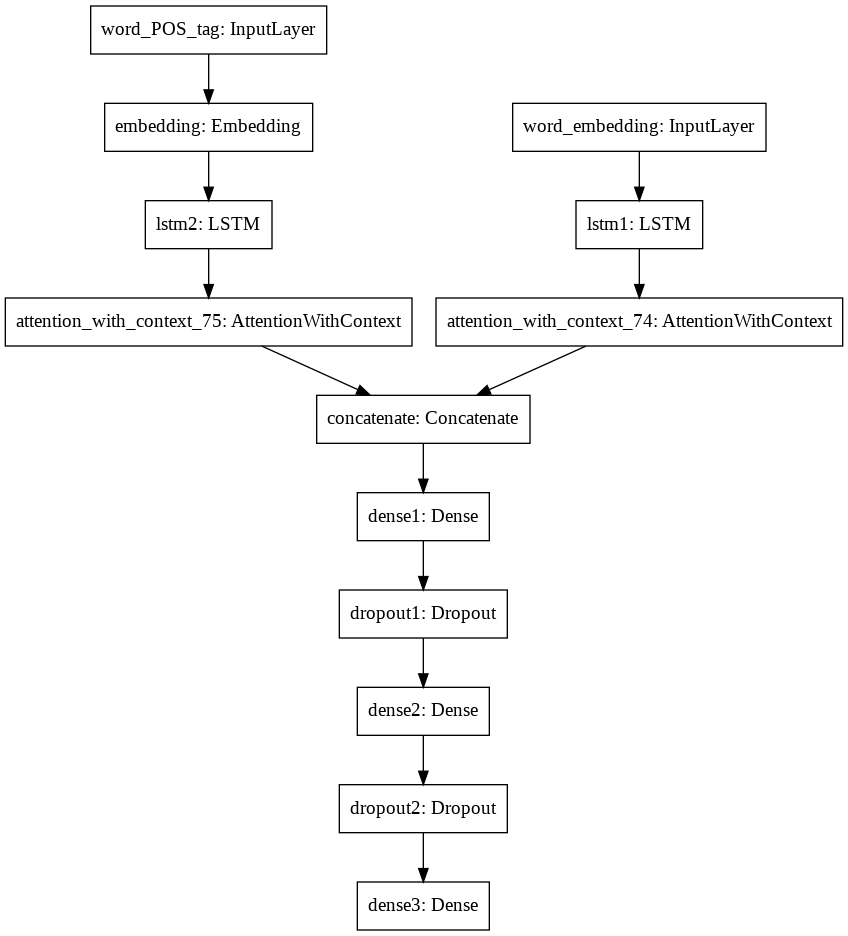

In [192]:
plot_model(elmo_lstm_attn_pos_attn, to_file='elmo_lstm_attn_pos_attn.png')

In [193]:
# checkpoint
filepath="elmo_lstm_attn_pos_attn_model-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

# fit the model
history = elmo_lstm_attn_pos_attn.fit([elmo_embedding, pos_data], label, validation_split=0.1, epochs=4, batch_size=32, callbacks=callbacks_list)

Train on 3317 samples, validate on 369 samples
Epoch 1/4
3317/3317 [==============================] - 34s 10ms/step - loss: 0.4873 - acc: 0.7673 - f1: 0.7524 - val_loss: 0.3481 - val_acc: 0.8509 - val_f1: 0.8450

Epoch 00001: val_acc improved from -inf to 0.85095, saving model to elmo_lstm_attn_pos_attn_model-01-0.85.hdf5
Epoch 2/4
3317/3317 [==============================] - 18s 5ms/step - loss: 0.3613 - acc: 0.8517 - f1: 0.8480 - val_loss: 0.3553 - val_acc: 0.8564 - val_f1: 0.8407

Epoch 00002: val_acc improved from 0.85095 to 0.85637, saving model to elmo_lstm_attn_pos_attn_model-02-0.86.hdf5
Epoch 3/4
3317/3317 [==============================] - 18s 5ms/step - loss: 0.2713 - acc: 0.8963 - f1: 0.8945 - val_loss: 0.3846 - val_acc: 0.8618 - val_f1: 0.8591

Epoch 00003: val_acc improved from 0.85637 to 0.86179, saving model to elmo_lstm_attn_pos_attn_model-03-0.86.hdf5
Epoch 4/4
3317/3317 [==============================] - 18s 6ms/step - loss: 0.1794 - acc: 0.9334 - f1: 0.9300 - val_lo

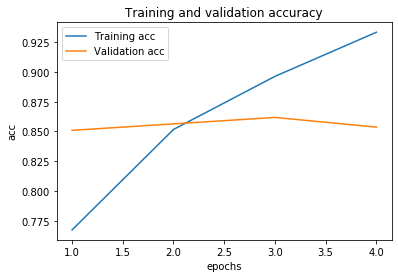

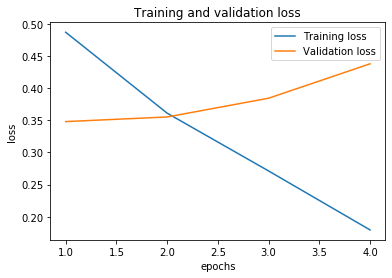

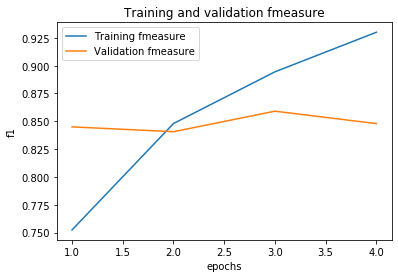

In [194]:
plot_result(history)

In [0]:
def build_elmo_lstm_pos_attn():
    inp1 = layers.Input(shape=(maxlen, 3072,), name='word_embedding') # To input elmo embeddings
    inp2 = layers.Input(shape=(maxlen,), name='word_POS_tag') # To input POS tag sequences
    
    x = layers.LSTM(64, dropout=0.5, return_sequences=True, name='lstm-1')(inp1)
    
    y = layers.Embedding(max_words, 100, input_length=maxlen, name='embedding')(inp2)
    y = layers.LSTM(64, dropout=0.5, return_sequences=True, name='lstm-2')(y)
    
    z = layers.Concatenate(axis=-1, name='concatenate')([x, y]) 
    z = AttentionWithContext()(z)
    
    z = layers.Dense(128, activation='relu', name='dense1')(z)
    z = layers.Dropout(0.5, name='dropout1')(z)
    z = layers.Dense(64, activation='relu', name='dense2')(z)
    z = layers.Dropout(0.3, name='dropout2')(z)

    pred = layers.Dense(1, activation='sigmoid', name='dense3')(z)
    model = Model(inputs=[inp1,inp2], outputs=pred, name='Elmo-LSTM+POS-LSTM Attention')
    model.compile(loss='binary_crossentropy',
                optimizer='rmsprop',
                metrics=['accuracy', f1])
    model.summary()
    return model

In [186]:
elmo_lstm_pos_attn = build_elmo_lstm_pos_attn()

Model: "Elmo-LSTM+POS-LSTM Attention"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
word_POS_tag (InputLayer)       (None, 50)           0                                            
__________________________________________________________________________________________________
word_embedding (InputLayer)     (None, 50, 3072)     0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 100)      10000       word_POS_tag[0][0]               
__________________________________________________________________________________________________
lstm-1 (LSTM)                   (None, 50, 64)       803072      word_embedding[0][0]             
_______________________________________________________________________

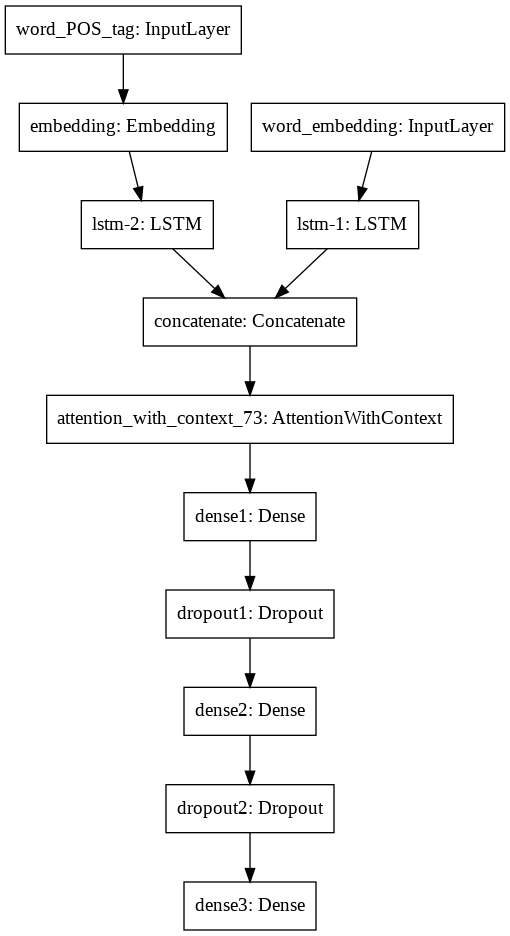

In [187]:
plot_model(elmo_lstm_pos_attn, to_file='elmo_lstm_pos_attn.png')

In [188]:
# checkpoint
filepath="elmo_lstm_pos_attn_model-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

# fit the model
history = elmo_lstm_pos_attn.fit([elmo_embedding, pos_data], label, validation_split=0.1, epochs=4, batch_size=32, callbacks=callbacks_list)

Train on 3317 samples, validate on 369 samples
Epoch 1/4
3317/3317 [==============================] - 33s 10ms/step - loss: 0.5222 - acc: 0.7513 - f1: 0.7427 - val_loss: 0.4448 - val_acc: 0.7805 - val_f1: 0.8112

Epoch 00001: val_acc improved from -inf to 0.78049, saving model to elmo_lstm_pos_attn_model-01-0.78.hdf5
Epoch 2/4
3317/3317 [==============================] - 18s 5ms/step - loss: 0.3950 - acc: 0.8309 - f1: 0.8283 - val_loss: 0.3560 - val_acc: 0.8347 - val_f1: 0.8379

Epoch 00002: val_acc improved from 0.78049 to 0.83469, saving model to elmo_lstm_pos_attn_model-02-0.83.hdf5
Epoch 3/4
3317/3317 [==============================] - 18s 5ms/step - loss: 0.3473 - acc: 0.8526 - f1: 0.8510 - val_loss: 0.3564 - val_acc: 0.8320 - val_f1: 0.8243

Epoch 00003: val_acc did not improve from 0.83469
Epoch 4/4
3317/3317 [==============================] - 18s 5ms/step - loss: 0.2817 - acc: 0.8869 - f1: 0.8822 - val_loss: 0.4023 - val_acc: 0.8184 - val_f1: 0.8181

Epoch 00004: val_acc did no

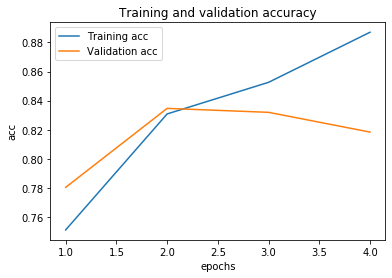

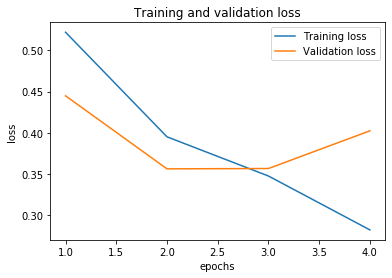

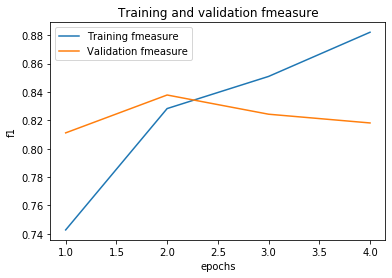

In [189]:
plot_result(history)

In [0]:
def build_elmo_pos_lstm_attn():
    inp1 = layers.Input(shape=(maxlen, 3072,)) # To input elmo embeddings
    inp2 = layers.Input(shape=(maxlen,)) # To input POS tag sequences
    
    x = layers.Embedding(max_words, 1024, input_length=maxlen)(inp2)
    
    z = layers.Concatenate(axis=-1)([inp1, x])
    z = layers.LSTM(64, dropout=0.5, return_sequences=True)(z)
    z = AttentionWithContext()(z)
    
    z = layers.Dense(128, activation='relu')(z)
    z = layers.Dropout(0.5)(z)
    z = layers.Dense(64, activation='relu')(z)
    z = layers.Dropout(0.3)(z)
    
    pred = layers.Dense(1, activation='sigmoid')(z)
    model = Model(inputs=[inp1,inp2], outputs=pred)
    model.compile(loss='binary_crossentropy',
                optimizer='rmsprop',
                metrics=['accuracy', f1])
    model.summary()
    return model

In [133]:
elmo_pos_lstm_attn = build_elmo_pos_lstm_attn()

Model: "model_26"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_68 (InputLayer)           (None, 50)           0                                            
__________________________________________________________________________________________________
input_67 (InputLayer)           (None, 50, 3072)     0                                            
__________________________________________________________________________________________________
embedding_33 (Embedding)        (None, 50, 1024)     102400      input_68[0][0]                   
__________________________________________________________________________________________________
concatenate_33 (Concatenate)    (None, 50, 4096)     0           input_67[0][0]                   
                                                                 embedding_33[0][0]        

In [134]:
# fit the model
history = elmo_pos_lstm_attn.fit([elmo_embedding, pos_data], label, validation_split=0.1, epochs=4, batch_size=32)

Train on 3317 samples, validate on 369 samples
Epoch 1/4
3317/3317 [==============================] - 25s 7ms/step - loss: 0.4962 - acc: 0.7633 - f1: 0.7563 - val_loss: 0.4559 - val_acc: 0.7913 - val_f1: 0.7993
Epoch 2/4
3317/3317 [==============================] - 12s 3ms/step - loss: 0.3738 - acc: 0.8372 - f1: 0.8352 - val_loss: 0.4416 - val_acc: 0.7967 - val_f1: 0.7950
Epoch 3/4
3317/3317 [==============================] - 12s 3ms/step - loss: 0.2835 - acc: 0.8927 - f1: 0.8877 - val_loss: 0.4799 - val_acc: 0.7995 - val_f1: 0.7821
Epoch 4/4
3317/3317 [==============================] - 11s 3ms/step - loss: 0.1865 - acc: 0.9279 - f1: 0.9261 - val_loss: 0.6115 - val_acc: 0.8049 - val_f1: 0.8150
